In [11]:
import pandas as pd

# Data from the echo nest research group

tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')


In [2]:
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [3]:
tracks.shape

(17734, 21)

In [4]:
tracks.columns

Index(['track_id', 'bit_rate', 'comments', 'composer', 'date_created',
       'date_recorded', 'duration', 'favorites', 'genre_top', 'genres',
       'genres_all', 'information', 'interest', 'language_code', 'license',
       'listens', 'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')

In [5]:
# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', precise_float=True)

In [7]:
echonest_metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [8]:
echonest_metrics.shape

(13129, 9)

In [9]:
echo_tracks = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')

In [10]:
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


In [12]:
corr_metrics = echonest_metrics.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.279829,0.102056,0.121991,-0.283206,-0.004059,-0.075077,0.004313,0.020201
acousticness,-0.279829,1.000000,-0.189599,-0.477273,0.110033,0.041319,0.038785,-0.110701,-0.085436
danceability,0.102056,-0.189599,1.000000,0.045345,-0.118033,-0.143339,0.171311,-0.094352,0.428515
energy,0.121991,-0.477273,0.045345,1.000000,-0.002412,0.045752,-0.008645,0.227324,0.219384
instrumentalness,-0.283206,0.110033,-0.118033,-0.002412,1.000000,-0.058593,-0.216689,0.023003,-0.145200
liveness,-0.004059,0.041319,-0.143339,0.045752,-0.058593,1.000000,0.073104,-0.007566,-0.017886
speechiness,-0.075077,0.038785,0.171311,-0.008645,-0.216689,0.073104,1.000000,0.032188,0.094794
tempo,0.004313,-0.110701,-0.094352,0.227324,0.023003,-0.007566,0.032188,1.000000,0.129911
valence,0.020201,-0.085436,0.428515,0.219384,-0.145200,-0.017886,0.094794,0.129911,1.000000


In [13]:
features = echo_tracks.drop(columns=['genre_top', 'track_id']) 

In [14]:
labels = echo_tracks['genre_top']

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

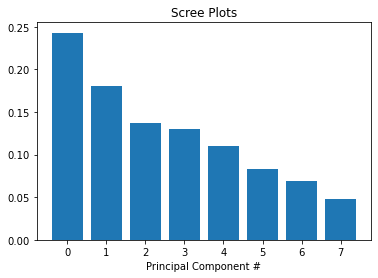

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')
plt.title('Scree Plots')
plt.show()

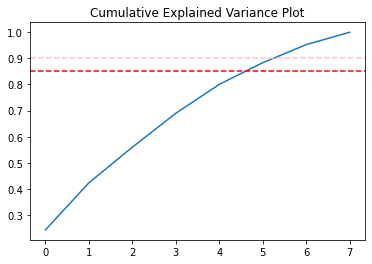

In [24]:
import numpy as np

cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--',color='red')
ax.axhline(y=0.90, linestyle='--',color='pink')
plt.title('Cumulative Explained Variance Plot')
plt.show()

In [25]:
n_components = 6

pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

train_X, test_X, train_y, test_y = train_test_split(
    pca_projection, labels, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_X, train_y)

pred_labels_tree = tree.predict(test_X)

In [28]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=10)
logreg.fit(train_X, train_y)
pred_labels_logit = logreg.predict(test_X)

In [30]:
from sklearn.ensemble import RandomForestClassifier

randreg = RandomForestClassifier(random_state=10)
randreg.fit(train_X, train_y)
pred_labels_rand = randreg.predict(test_X)

In [32]:
from sklearn.ensemble import ExtraTreesClassifier

etcreg = ExtraTreesClassifier(random_state=10)
etcreg.fit(train_X, train_y)
pred_labels_etc = etcreg.predict(test_X)

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

gbcreg = GradientBoostingClassifier(random_state=10)
gbcreg.fit(train_X, train_y)
pred_labels_gbc = gbcreg.predict(test_X)

In [39]:
import xgboost as xg

xgreg = xg.XGBClassifier(random_state=10)
xgreg.fit(train_X, train_y)
pred_labels_xg = xgreg.predict(test_X)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:52:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_y, pred_labels_tree)
class_rep_log = classification_report(test_y, pred_labels_logit)
class_rep_rand = classification_report(test_y, pred_labels_rand)
class_rep_etc = classification_report(test_y, pred_labels_etc)
class_rep_gbc = classification_report(test_y, pred_labels_gbc)
class_rep_xg = classification_report(test_y, pred_labels_xg)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)
print("Random Forest: \n", class_rep_rand)
print("Extra Trees: \n", class_rep_etc)
print("Gradient Boost: \n", class_rep_gbc)
print("XgBoost: \n", class_rep_xg)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201

Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.60      0.69       235
        Rock       0.91      0.97      0.94       966

    accuracy                           0.90      1201
   macro avg       0.86      0.79      0.82      1201
weighted avg     

In [48]:
#Result: Thus XG Boost selected to boost performance
#Observation: Lower f1 score
#Reason: Imbalanced dataset

In [49]:
#Way 1: SMOTE

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
train_X_res, train_y_res = sm.fit_resample(train_X, train_y.ravel())
test_X_res, test_y_res = sm.fit_resample(test_X, test_y.ravel())

In [50]:
import xgboost as xg

xgreg = xg.XGBClassifier(random_state=10)
xgreg.fit(train_X_res, train_y_res)
pred_labels_xg = xgreg.predict(test_X_res)

class_rep_xg = classification_report(test_y_res, pred_labels_xg)

print("XgBoost: \n", class_rep_xg)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:59:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XgBoost: 
               precision    recall  f1-score   support

     Hip-Hop       0.91      0.78      0.84       966
        Rock       0.81      0.92      0.86       966

    accuracy                           0.85      1932
   macro avg       0.86      0.85      0.85      1932
weighted avg       0.86      0.85      0.85      1932



In [51]:
#SMOTE improved the f1 scores

In [53]:
#Way 2 - Balancing the dataset manually

hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

rock_hop_bal = pd.concat([rock_only, hop_only])

features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

train_X, test_X, train_y, test_y = train_test_split(
    pca_projection, labels, random_state=10)

In [56]:
import xgboost as xg

xgreg = xg.XGBClassifier(random_state=10)
xgreg.fit(train_X, train_y)
pred_labels_xg = xgreg.predict(test_X)

class_rep_xg = classification_report(test_y, pred_labels_xg)

print("XgBoost: \n", class_rep_xg)

[01:05:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XgBoost: 
               precision    recall  f1-score   support

     Hip-Hop       0.85      0.80      0.83       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.83       455
   macro avg       0.83      0.83      0.83       455
weighted avg       0.83      0.83      0.83       455



In [57]:
#Way 1 gives better higher f1 scores

In [67]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)
randreg = RandomForestClassifier(random_state=10)
etcreg = ExtraTreesClassifier(random_state=10)
gbboostreg = GradientBoostingClassifier(random_state=10)
xgreg = xg.XGBClassifier(random_state=10)

tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)
rand_score = cross_val_score(randreg, pca_projection, labels, cv=kf)
etc_score = cross_val_score(etcreg, pca_projection, labels, cv=kf)
gb_score = cross_val_score(gbboostreg, pca_projection, labels, cv=kf)
xg_score = cross_val_score(xgreg, pca_projection, labels, cv=kf)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [66]:
print("\nDecision Tree:", round(np.mean(tree_score),2), round(np.std(tree_score),2),
      "\nLogistic Regression:", round(np.mean(logit_score),2),round(np.std(logit_score),2),
     "\nRandom Forest :", round(np.mean(rand_score),2),round(np.std(rand_score),2),
     "\nExtra Trees:", round(np.mean(etc_score),2),round(np.std(etc_score),2),
      "\nGradient Boost:", round(np.mean(gb_score),2),round(np.std(gb_score),2),
      
      "\nXgBoost:", round(np.mean(xg_score),2),round(np.std(xg_score),2)
     )


Decision Tree: 0.75 0.04 
Logistic Regression: 0.78 0.02 
Random Forest : 0.81 0.02 
Extra Trees: 0.82 0.03 
Gradient Boost: 0.8 0.03 
XgBoost: 0.8 0.03


In [68]:
#Selecting Extra Trees

In [83]:
test = echo_tracks.iloc[0][1:-1]

In [102]:
test_pca = pca.transform(scaler.transform(np.array(test).reshape(1,-1)))

In [112]:
test_pca

array([[ 0.92607418,  0.83507183,  0.00119811, -0.83028383, -0.21387017,
         0.49485354]])

In [103]:
echo_tracks.columns

Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence',
       'genre_top'],
      dtype='object')

In [106]:
etc = ExtraTreesClassifier(random_state=10)
etcreg = etc.fit(pca_projection,labels)
etcreg.predict(test_pca)
#predict(test_pca)

array(['Hip-Hop'], dtype=object)

In [111]:
#cross check output
echo_tracks.iloc[0]

track_id                    2
acousticness         0.416675
danceability         0.675894
energy               0.634476
instrumentalness    0.0106281
liveness             0.177647
speechiness           0.15931
tempo                 165.922
valence              0.576661
genre_top             Hip-Hop
Name: 0, dtype: object